In [2]:
import numpy as np
import pickle
import os
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

In [3]:
# Define the root directory
name = 'Dataset-st_binary--RE-True--W-True--Epochs-15000--D-5--RH-25--LR-0.1--LP-False--CUDA-True'
root = 'D:/study/thesis/project/HBDM-main/ppi_results/models/'+name
dataset = name.split('--')[0].split('-')[1]

## latent representation

In [4]:
### get node and 1d,2d
file_path_d = 'D:/study/thesis/project/HBDM-main/ppi_results/latent/'+name +'.pkl'
with open(file_path_d, 'rb') as file:
    loaded_tensor = pickle.load(file)

tensor = loaded_tensor.cpu()
node_rep = tensor.detach().numpy()


df_latent = pd.DataFrame()
for d in range(node_rep.shape[1]):
    col_name = str(d+1)+'d'
    df_latent[col_name] = node_rep.T[d]
df_latent['node'] = df_latent.index

df = df_latent
df.head(3)

,1d,2d,3d,4d,5d,node
0,-0.630324,-1.188974,-2.247292,-0.356064,-1.271949,0
1,-3.499215,0.182973,-1.861458,-0.530556,-3.432482,1
2,-2.654869,-9.166069,-3.647890,6.334859,-4.936882,2


## k nearest neighbor method

In [6]:
import random
from sklearn.neighbors import KDTree
from sklearn.model_selection import KFold

### from DisGeNET disease

In [5]:
with open(r'D:\study\thesis\project\HBDM-main\data\datasets\ppi\ppi_aliases2stringId.pkl', 'rb') as f:
    ppi_name2stringId = pickle.load(f)
with open(r'D:\study\thesis\project\HBDM-main\data\datasets\ppi\ppi_name2stringId.pkl', 'rb') as file:
    name2stringId = pickle.load(file)
with open('D:/study/thesis/project/HBDM-main/data/datasets/'+dataset+'/ppi_index.pkl', 'rb') as f:
    value_to_index_mapping = pickle.load(f)
with open('D:/study/thesis/project/HBDM-main/data/datasets/st/ppi_index.pkl', 'rb') as f:
    st_dict = pickle.load(f)   
names = set(ppi_name2stringId.keys())
tissue_genes = set(st_dict.keys())
network_genes = set(value_to_index_mapping.keys())
def convert_stringId(alias):
    try:
        stringId = name2stringId[alias]
    except:
        #print(alias, 'can\'t be converted by name2stringId! Now trying aliases2stringId.')
        try:
            stringId = ppi_name2stringId[alias]
        except:
            #print(alias, 'can\'t be converted by aliases2stringId! Now return None.')
            stringId = None
    #print(alias, stringId)
    return stringId

In [7]:
def folder_check(folder_path):
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    else:
        pass
def get_disease_genes(disease_df,tissue_genes):
    group_node = set()
    for gene in disease_df['Gene']:
        if gene in names:
            stringid = convert_stringId(gene)
            if stringid in tissue_genes:
                if stringid in network_genes:  
                    node = value_to_index_mapping[stringid]
                    group_node.add(node)
    return list(group_node)

In [8]:
def calculate_precision_recall_curve(y_true, y_scores):
    # Sort the scores and true labels in descending order of scores
    desc_score_indices = np.argsort(y_scores)[::-1]
    y_scores = np.array(y_scores)[desc_score_indices]
    y_true = np.array(y_true)[desc_score_indices]

    precision_values = []
    recall_values = []
    num_true_positives = 0
    num_predicted_positives = 0
    total_true_positives = sum(y_true)
    
    for i in range(len(y_true)):
        num_predicted_positives += 1
        if y_true[i] == 1:
            num_true_positives += 1
        precision = num_true_positives / num_predicted_positives
        recall = num_true_positives / total_true_positives
        precision_values.append(precision)
        recall_values.append(recall)

    return precision_values, recall_values

def calculate_auc_pr(precision, recall):
    return np.trapz(precision, recall)
def find_best_thresholds(precision, recall, thresholds):
    best_f1 = 0
    best_precision = 0
    best_recall = 0
    best_precision_threshold = thresholds[0]
    best_recall_threshold = thresholds[0]
    best_f1_threshold = thresholds[0]
    for i in range(len(thresholds)):
        if precision[i] + recall[i] != 0:
            f1 = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i])

            if precision[i] > best_precision:
                best_precision = precision[i]
                # best_precision_threshold = thresholds[i]
                best_precision_threshold = i
            if recall[i] > best_recall:
                best_recall = recall[i]
                # best_recall_threshold = thresholds[i]
                best_recall_threshold=i
            if f1 > best_f1:
                best_f1 = f1
                # best_f1_threshold = thresholds[i]
                best_f1_threshold = i

    return best_f1_threshold, best_f1
def results_f1_aucpr(predicted_positives,true_positives,plot=False):
    # Example usage
    precision_values, recall_values = calculate_precision_recall_curve(true_positives, predicted_positives)
    auc_pr = calculate_auc_pr(precision_values, recall_values)



    # Obtain the corresponding thresholds
    thresholds = sorted(predicted_positives, reverse=True)

    best_f1_threshold, best_f1, = find_best_thresholds(precision_values, recall_values, thresholds)

    print("Best Threshold for F1:", best_f1_threshold)
    print("Best F1:", best_f1)
    print('precision here ', precision_values[best_f1_threshold])
    print('recall here ', recall_values[best_f1_threshold])
    print("AUC-PR:", auc_pr)
    if plot:
        # Plot the Precision-Recall curve
        plt.figure(figsize=(8, 6))
        plt.plot(recall_values, precision_values, marker='o', linestyle='-')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.grid(True)

        line_colors = ['r', 'b', 'g', 'y']

        # Add vertical lines at i=10, i=50, i=100, and i=200 with different colors
        top_cuts = [10, 50, 100, 200]

        for i, top_cut in enumerate(top_cuts):
            color_index = i % len(line_colors)  # Cyclically select colors from the list
            plt.axvline(x=recall_values[top_cut], color=line_colors[color_index], linestyle='--', label=f'Top {top_cut}')
        # Show or save the plot
        plt.legend()  # Add a legend to explain the vertical lines
        plt.show()

    return [best_f1, auc_pr]


In [17]:
def top_hit(predict_df,test_nodes):
    precision = []
    recall = []
    for top_cut in [10,50,100,150,200]:
        sub_predict_df = predict_df[:top_cut]
        tp_num = len(sub_predict_df[sub_predict_df['true']==1])
        np_num = len(sub_predict_df[sub_predict_df['true']==0])
        fn_num = len(set(test_nodes)-set(sub_predict_df[sub_predict_df['true']==1]['neighbor'].tolist()))
        precision.append(tp_num/(tp_num+np_num))
        recall.append(tp_num/(tp_num+fn_num))
    return precision,recall

In [10]:
def test_f1_auc(file_name,group_node,k_values):
    # Define your range of k values and leaf_size values

    # Split your data into 5 folds
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    with open(file_name, "w") as f:
        for k in k_values:
            k+=1
            results = []

            # Build a k-d tree from the points
            kdtree = KDTree(df[[col for col in df.columns if col.endswith('d')]].to_numpy(), leaf_size=20)
            for train_index, test_index in kf.split(group_node):
                train_nodes = [group_node[i] for i in train_index]
                test_nodes = [group_node[i] for i in test_index]
                start = []
                dist = []
                neighbor = []
                random_nodes = []
                for i in train_nodes:
                    given_point = df[df['node']==i][[col for col in df.columns if col.endswith('d')]].to_numpy()
                    # Perform a k-NN search to find the k+1 nearest neighbors
                    distances, indices = kdtree.query(given_point, k=k)
                    start += (k-1)*[i]
                    dist += distances.reshape(-1).tolist()[1:]
                    neighbor += indices.reshape(-1).tolist()[1:]
                # random_nodes = random.sample(list(set(df['node'].tolist())-set(train_nodes)), (k-1))

                neighbor_df = pd.DataFrame({'start': start, 'neighbor': neighbor, 'distance': dist})
                neighbor_df = neighbor_df[~neighbor_df['neighbor'].isin(train_nodes)]
                predict_df = neighbor_df['neighbor'].value_counts().to_frame()
                predict_df.reset_index(inplace=True)
                predict_df['true'] = predict_df.apply(lambda row: 1 if row['neighbor'] in test_nodes else 0, axis=1)
                predicted_positives = predict_df['count']
                true_positives = predict_df['true']
                results.append(results_f1_aucpr(predicted_positives,true_positives,plot=True))
            results = np.array(results)
            f1 = np.mean(results[:, 0])
            auc = np.mean(results[:, 1])
            # print(f"k={k-1}, leaf_size={20}\tF1: {f1}\tAUC_PR: {auc}", file=f)

In [11]:
def test_pr(file_name,group_node,    k_values ):
    # Define your range of k values and leaf_size values
    # k_values = range(2,10)

    # Split your data into 5 folds
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    with open(file_name, "w") as f:
        for k in k_values:
            k+=1
            pr = []
            re = []

            # Build a k-d tree from the points
            kdtree = KDTree(df[[col for col in df.columns if col.endswith('d')]].to_numpy(), leaf_size=20)
            for train_index, test_index in kf.split(group_node):
                train_nodes = [group_node[i] for i in train_index]
                test_nodes = [group_node[i] for i in test_index]
                start = []
                dist = []
                neighbor = []

                for i in train_nodes:
                    given_point = df[df['node']==i][[col for col in df.columns if col.endswith('d')]].to_numpy()
                    # Perform a k-NN search to find the k+1 nearest neighbors
                    distances, indices = kdtree.query(given_point, k=k)
                    start += (k-1)*[i]
                    dist += distances.reshape(-1).tolist()[1:]
                    neighbor += indices.reshape(-1).tolist()[1:]
                # random_nodes = random.sample(list(set(df['node'].tolist())-set(train_nodes)), (k-1))

                neighbor_df = pd.DataFrame({'start': start, 'neighbor': neighbor, 'distance': dist})
                neighbor_df = neighbor_df[~neighbor_df['neighbor'].isin(train_nodes)]
                predict_df = neighbor_df['neighbor'].value_counts().to_frame()
                predict_df.reset_index(inplace=True)
                predict_df['true'] = predict_df.apply(lambda row: 1 if row['neighbor'] in test_nodes else 0, axis=1)
                
                pr_re = top_hit(predict_df,test_nodes)

                pr.append(pr_re[0])
                re.append(pr_re[1])
            avg_pr = np.mean(np.array(pr).T, axis=1)
            avg_re = np.mean(np.array(re).T, axis=1)
    return avg_pr,avg_re

In [21]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
kf.split(group_node)

<generator object _BaseKFold.split at 0x0000024DC91D73C0>

In [28]:
for train, test in kf.split(group_node):
    print(len(train),len(test))

1327 332
1327 332
1327 332
1327 332
1328 331


Myocardial_Infarction 1476
Best Threshold for F1: 247
Best F1: 0.24000000000000002
precision here  0.1935483870967742
recall here  0.3157894736842105
AUC-PR: 0.13172755221796134


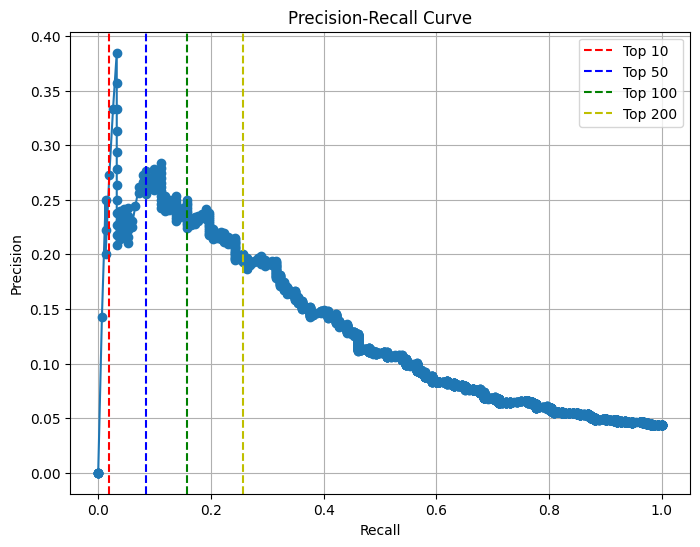

Best Threshold for F1: 712
Best F1: 0.14736842105263157
precision here  0.08835904628330996
recall here  0.44366197183098594
AUC-PR: 0.09975494319045586


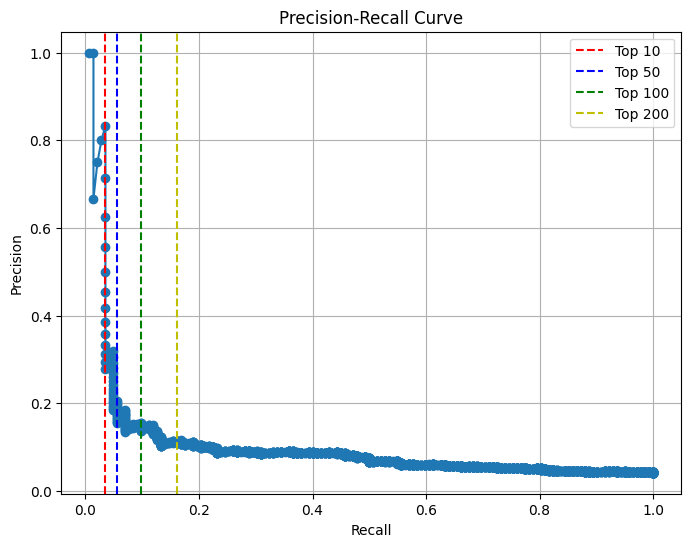

Best Threshold for F1: 231
Best F1: 0.15591397849462366
precision here  0.125
recall here  0.20714285714285716
AUC-PR: 0.07787859329420617


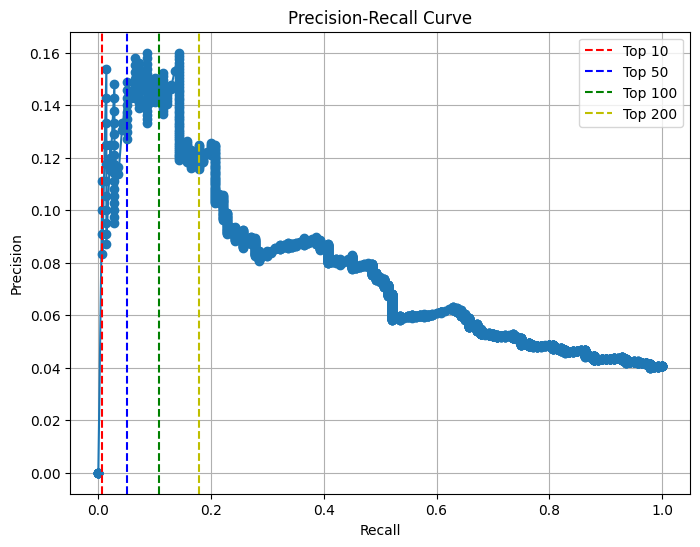

Best Threshold for F1: 221
Best F1: 0.18276762402088773
precision here  0.15765765765765766
recall here  0.21739130434782608
AUC-PR: 0.11920710069012068


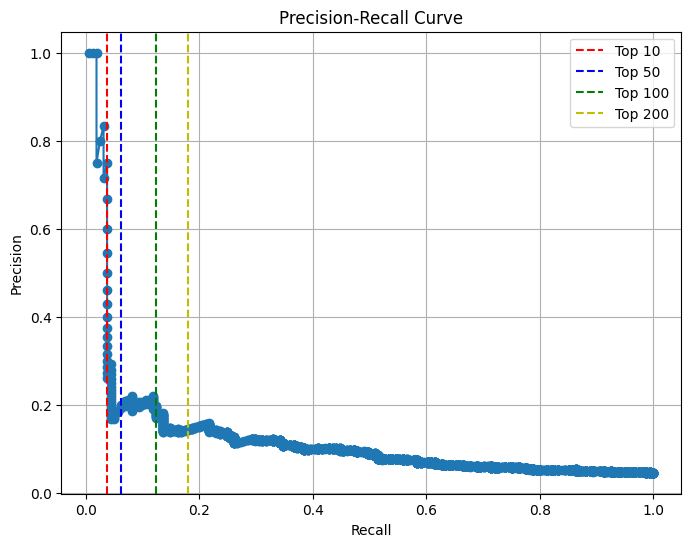

Best Threshold for F1: 221
Best F1: 0.17032967032967034
precision here  0.13963963963963963
recall here  0.21830985915492956
AUC-PR: 0.0889504742904085


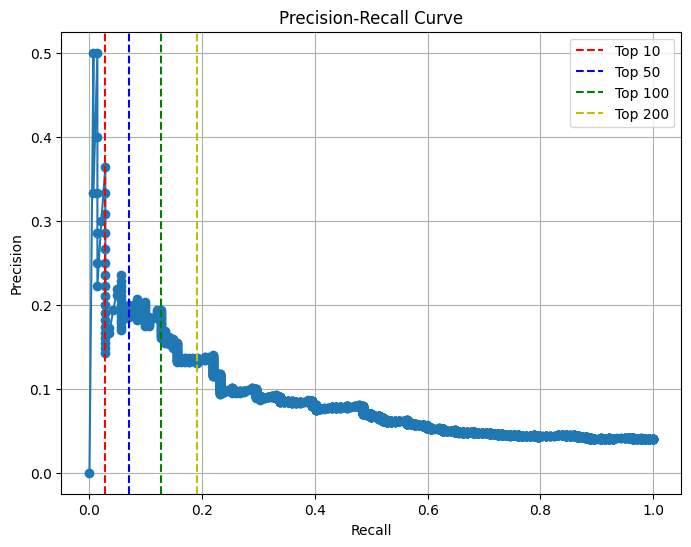

In [29]:
disease_root = r'D:\study\thesis\project\HBDM-main\data\disease'
output_root = r'D:\study\thesis\project\HBDM-main\ppi_results\test_results'
disease_list = ['Atherosclerosis.tsv','Cardiovascular_Diseases.tsv','Coronary_artery_disease.tsv','Coronary_heart_disease.tsv','Myocardial_Infarction.tsv']
for filename in disease_list:
    filename = disease_list[4]
    if filename.endswith('txt'):
        disease_df = pd.read_csv(os.path.join(disease_root,filename))
    elif 'drug' in filename:
        disease_df = pd.read_csv(os.path.join(disease_root,filename),sep='\t')
        disease_df['Gene']=disease_df['symbol']
    elif filename.endswith('tsv'):
        disease_df = pd.read_csv(os.path.join(disease_root,filename),sep='\t')
    folder_path = os.path.join(output_root,filename.split('.')[0])
    folder_check(folder_path)
    group_node = get_disease_genes(disease_df,tissue_genes)
    print(filename.split('.')[0], len(group_node))
    file_name = os.path.join(folder_path,name+'.test')
    cutpr, cutre = test_pr(file_name,group_node,[5])
    test_f1_auc(file_name,group_node,[5])
    break

In [41]:
cutpr

array([0.24      , 0.21      , 0.19333333, 0.195     , 0.176     ])

In [23]:
cutpr*[10,20,30,40,50]

array([2.4 , 3.52, 4.98, 5.76, 6.85])

In [26]:
(1-cutre)*277

array([274.59347826, 268.17318841, 260.35072464, 255.33695652,
       249.51884058])

In [11]:
# # Define your range of k values and leaf_size values
# k_values = [2, 3, 4, 5, 6, 7, 8, 9]

# # Split your data into 5 folds
# kf = KFold(n_splits=5, shuffle=True, random_state=42)
# with open(folder_path, "w") as f:
#     for k in k_values:
#         k+=1
#         precision_scores = []
#         coverage_scores = []
#         random_precision_scores = []
#         random_coverage_scores = []

#         # Build a k-d tree from the points
#         kdtree = KDTree(df[[col for col in df.columns if col.endswith('d')]].to_numpy(), leaf_size=20)
#         for train_index, test_index in kf.split(group_node):
#             train_nodes = [group_node[i] for i in train_index]
#             test_nodes = [group_node[i] for i in test_index]

#             start = []
#             dist = []
#             neighbor = []
#             random_nodes = []
#             for i in train_nodes:
#                 given_point = df[df['node']==i][[col for col in df.columns if col.endswith('d')]].to_numpy()
#                 # Perform a k-NN search to find the k+1 nearest neighbors
#                 distances, indices = kdtree.query(given_point, k=k)
#                 start += (k-1)*[i]
#                 dist += distances.reshape(-1).tolist()[1:]
#                 neighbor += indices.reshape(-1).tolist()[1:]

#                 random_nodes += random.sample(list(set(df['node'].tolist())-set(train_nodes)), (k-1))

#             neighbor_df = pd.DataFrame({'start': start, 'neighbor': neighbor, 'distance': dist})
#             cover_df = neighbor_df[neighbor_df['neighbor'].isin(test_nodes)]
#             # if len(cover_df) == 0:
#             #     print(test_nodes)
#             # Append precision and coverage scores to lists
#             precision_scores.append(len(cover_df) / len(neighbor_df))
#             coverage_scores.append(len(cover_df['neighbor'].unique()) / len(test_nodes))
            
#             ############################ random
#             random_cover = []
#             for j in random_nodes:
#                 if j in test_nodes:
#                     random_cover.append(j)

#             random_precision_scores.append(len(random_cover)/ len(random_nodes))
#             random_coverage_scores.append(len(set(random_cover))/ len(test_nodes))

#         ###### choose one fold to check details
#         ranked = neighbor_df.sort_values(by='distance')
#         coverage = 0
#         for top_threshold in range(50, len(neighbor_df), 50):
#             cover = []
#             top_recommend = ranked['neighbor'].tolist()[:top_threshold]
#             for i in top_recommend: 
#                 if i in test_nodes:
#                     cover.append(i)
#             if len(set(cover)) / len(test_nodes) > coverage:
#                 coverage = len(set(cover)) / len(test_nodes)
#                 top_precision = len(cover) / top_threshold
#                 print(f'top {top_threshold} precision: {top_precision}', file=f)
#                 print(f'top {top_threshold} coverage: {coverage}', file=f)
#             else:
#                 print('coverage limitation', file=f)
#                 break
#         # Calculate the average precision and coverage scores for the current k and leaf_size
#         avg_precision = sum(precision_scores) / len(precision_scores)
#         avg_coverage = sum(coverage_scores) / len(coverage_scores)

#         random_avg_precision = sum(random_precision_scores) / len(random_precision_scores)
#         random_avg_coverage = sum(random_coverage_scores) / len(random_coverage_scores)
        
#         print(f"k={k-1}, leaf_size={20}",'\t',"Average Precision:", avg_precision,'\t',"Average Coverage:", avg_coverage)
#         result_line = f"k={k-1}, leaf_size={20}\tAverage Precision: {avg_precision}\tAverage Coverage: {avg_coverage}\n"
#         print(f"k={k-1}, leaf_size={20}\tRandom Precision: {random_avg_precision}\tRandom Coverage: {random_avg_coverage}", file=f)
#         f.write(result_line)
